<a href="https://colab.research.google.com/github/mohammednaveel03-del/bert-variant-sentiment-analysis/blob/main/SentimentAnalysis_MohammedNaveel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install --no-cache-dir "transformers" "datasets" "evaluate" "accelerate" "scikit-learn"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.8 MB/s eta 0:00:00


In [ ]:
import numpy as np, pandas as pd
import sklearn
import transformers, datasets, evaluate, accelerate

print("python ok")
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("sklearn", sklearn.__version__)
print("transformers", transformers.__version__)
print("datasets", datasets.__version__)
print("evaluate", evaluate.__version__)
print("accelerate", accelerate.__version__)


python ok
numpy 2.0.2
pandas 2.2.2
sklearn 1.6.1
transformers 4.57.3
datasets 4.0.0
evaluate 0.4.6
accelerate 1.12.0


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


CUDA available: True
Device: cuda


In [ ]:
!pip -q install --no-cache-dir "transformers" "datasets" "evaluate" "accelerate" "scikit-learn"

In [ ]:
import os, random, time
import numpy as np
import pandas as pd
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
import transformers, datasets, evaluate, accelerate, sklearn

print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("evaluate:", evaluate.__version__)
print("accelerate:", accelerate.__version__)
print("sklearn:", sklearn.__version__)


transformers: 4.57.3
datasets: 4.0.0
evaluate: 0.4.6
accelerate: 1.12.0
sklearn: 1.6.1


In [ ]:
DATA_URL = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv"

TEXT_COL = "tweet"
LABEL_COL = "label"

MAX_LEN = 96
BATCH_SIZE = 16
EPOCHS = 2
LR = 2e-5

OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)


In [ ]:
import pandas as pd

df = pd.read_csv(DATA_URL)

print("Columns:", df.columns.tolist())
print("Rows:", len(df))
print(df.head(3))

# Basic sanity checks
assert TEXT_COL in df.columns, f"Missing text column: {TEXT_COL}"
assert LABEL_COL in df.columns, f"Missing label column: {LABEL_COL}"

print("\nLabel distribution:")
print(df[LABEL_COL].value_counts(dropna=False))


Columns: ['id', 'label', 'tweet']
Rows: 31962
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty

Label distribution:
label
0    29720
1     2242
Name: count, dtype: int64


In [ ]:
# Drop empty tweets
df[TEXT_COL] = df[TEXT_COL].astype(str)
df = df[df[TEXT_COL].str.strip().astype(bool)].copy()

# Ensure labels are ints (0/1)
df[LABEL_COL] = df[LABEL_COL].astype(int)

# Remove exact duplicate rows (optional but safe)
df = df.drop_duplicates(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)

print("After cleaning -> Rows:", len(df))
print("Label distribution:\n", df[LABEL_COL].value_counts())


After cleaning -> Rows: 29530
Label distribution:
 label
0    27517
1     2013
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df[LABEL_COL]
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=SEED, stratify=temp_df[LABEL_COL]
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

# Save splits for reproducibility
train_df.to_csv(os.path.join(OUT_DIR, "train_split.csv"), index=False)
val_df.to_csv(os.path.join(OUT_DIR, "val_split.csv"), index=False)
test_df.to_csv(os.path.join(OUT_DIR, "test_split.csv"), index=False)
print("Saved splits to:", OUT_DIR)


Train: 23624 Val: 2953 Test: 2953
Saved splits to: /content/outputs


In [ ]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

print(train_ds)
print(val_ds)
print(test_ds)


Dataset({
    features: ['id', 'label', 'tweet'],
    num_rows: 23624
})
Dataset({
    features: ['id', 'label', 'tweet'],
    num_rows: 2953
})
Dataset({
    features: ['id', 'label', 'tweet'],
    num_rows: 2953
})


In [ ]:
# Show a few examples from each class to verify labels look correct
print("Label 0 samples:")
print(train_df[train_df[LABEL_COL] == 0][TEXT_COL].head(3).to_list())

print("\nLabel 1 samples:")
print(train_df[train_df[LABEL_COL] == 1][TEXT_COL].head(3).to_list())


Label 0 samples:
["it's actually stopped raining......for now.....so bike ride it is then!ð\x9f\x98\x8að\x9f\x9a´ð\x9f\x8f» #cycling #mtb  â\x80¦ ", '@user   to see you', "@user stop...can't handle their drink or the heat along with bad manners and racism in a volatile city...  "]

Label 1 samples:
['good afternoon sweety! ð\x9f\x98\x83 send me letter â\x99\x8bï¸\x8f  ', 'well,these sewer rats don\'t take a cent from me,....i don\'t use to watch "football",......but now,i hate it! ', '@user #trump used #hate,  and #putin to win the white house #trump presses attack on khan family and g.o.p. leaders ']


In [ ]:
import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="binary")["f1"]
    return {"accuracy": acc, "f1": f1}

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from transformers import AutoTokenizer

def build_tokenized_datasets(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    def tok(batch):
        return tokenizer(batch[TEXT_COL], truncation=True, max_length=MAX_LEN)

    tok_train = train_ds.map(tok, batched=True)
    tok_val   = val_ds.map(tok, batched=True)
    tok_test  = test_ds.map(tok, batched=True)

    # Rename label column to "labels" for Trainer
    tok_train = tok_train.rename_column(LABEL_COL, "labels")
    tok_val   = tok_val.rename_column(LABEL_COL, "labels")
    tok_test  = tok_test.rename_column(LABEL_COL, "labels")

    # Keep only what Trainer needs (plus the raw tweet column for later analysis if you want)
    keep_cols = ["input_ids", "attention_mask", "labels"]
    if TEXT_COL in tok_train.column_names:
        keep_cols = [TEXT_COL] + keep_cols

    tok_train = tok_train.remove_columns([c for c in tok_train.column_names if c not in keep_cols])
    tok_val   = tok_val.remove_columns([c for c in tok_val.column_names if c not in keep_cols])
    tok_test  = tok_test.remove_columns([c for c in tok_test.column_names if c not in keep_cols])

    return tokenizer, tok_train, tok_val, tok_test


In [ ]:
MODEL_NAMES = {
    "distilbert": "distilbert-base-uncased",
    "bert": "bert-base-uncased",
    "roberta": "roberta-base",
}

print(MODEL_NAMES)


{'distilbert': 'distilbert-base-uncased', 'bert': 'bert-base-uncased', 'roberta': 'roberta-base'}


In [ ]:
import os
import torch
import pandas as pd
import numpy as np

from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

def train_one_model(model_key: str):
    model_name = MODEL_NAMES[model_key]
    print(f"\n=== Training: {model_key} ({model_name}) ===")

    tokenizer, tok_train, tok_val, tok_test = build_tokenized_datasets(model_name)
    collator = DataCollatorWithPadding(tokenizer=tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

    run_dir = os.path.join(OUT_DIR, f"ckpt_{model_key}")

    # NOTE: In transformers 4.57+, the argument is eval_strategy (not evaluation_strategy)
    args = TrainingArguments(
        output_dir=run_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        logging_steps=50,
        report_to="none",
        seed=SEED,
        fp16=torch.cuda.is_available(),
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tok_train,
        eval_dataset=tok_val,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # Test evaluation
    test_metrics = trainer.evaluate(tok_test)
    print("Test metrics:", test_metrics)

    # Predictions for error analysis
    pred_out = trainer.predict(tok_test)
    logits = pred_out.predictions
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    y_pred = np.argmax(logits, axis=-1)
    y_true = pred_out.label_ids

    out_pred = test_df.copy().reset_index(drop=True)
    out_pred["y_true"] = y_true
    out_pred["y_pred"] = y_pred
    out_pred["conf_pred"] = probs.max(axis=1)
    out_pred["correct"] = (out_pred["y_true"] == out_pred["y_pred"])

    # Save outputs
    metrics_path = os.path.join(OUT_DIR, f"test_metrics_{model_key}.json")
    pd.Series(test_metrics).to_json(metrics_path)

    pred_path = os.path.join(OUT_DIR, f"predictions_{model_key}.csv")
    out_pred.to_csv(pred_path, index=False)

    mis_path = os.path.join(OUT_DIR, f"misclassified_{model_key}.csv")
    out_pred[~out_pred["correct"]].to_csv(mis_path, index=False)

    print("Saved:", metrics_path)
    print("Saved:", pred_path)
    print("Saved:", mis_path)

    return test_metrics, out_pred

# Run DistilBERT pipeline test
distil_metrics, distil_preds = train_one_model("distilbert")



=== Training: distilbert (distilbert-base-uncased) ===


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/23624 [00:00<?, ? examples/s]

Map:   0%|          | 0/2953 [00:00<?, ? examples/s]

Map:   0%|          | 0/2953 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3439962386.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.158600,0.140162,0.961057,0.622951
2,0.078100,0.105623,0.972909,0.788360


Test metrics: {'eval_loss': 0.10046520829200745, 'eval_accuracy': 0.9725702675245513, 'eval_f1': 0.7692307692307693, 'eval_runtime': 1.6467, 'eval_samples_per_second': 1793.265, 'eval_steps_per_second': 112.345, 'epoch': 2.0}
Saved: /content/outputs/test_metrics_distilbert.json
Saved: /content/outputs/predictions_distilbert.csv
Saved: /content/outputs/misclassified_distilbert.csv


In [ ]:
all_results = []
all_preds = {}

for model_key in MODEL_NAMES.keys():
    metrics, preds_df = train_one_model(model_key)

    all_results.append({
        "model": model_key,
        "eval_loss": float(metrics.get("eval_loss")),
        "accuracy": float(metrics.get("eval_accuracy")),
        "f1": float(metrics.get("eval_f1")),
        "epoch": float(metrics.get("epoch", EPOCHS))
    })
    all_preds[model_key] = preds_df

results_df = pd.DataFrame(all_results).sort_values("f1", ascending=False)
print(results_df)

results_path = os.path.join(OUT_DIR, "results_metrics.csv")
results_df.to_csv(results_path, index=False)
print("Saved:", results_path)



=== Training: distilbert (distilbert-base-uncased) ===


Map:   0%|          | 0/23624 [00:00<?, ? examples/s]

Map:   0%|          | 0/2953 [00:00<?, ? examples/s]

Map:   0%|          | 0/2953 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3439962386.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.159400,0.136155,0.961395,0.625000
2,0.074800,0.114456,0.972232,0.783069


Test metrics: {'eval_loss': 0.10770824551582336, 'eval_accuracy': 0.9729089061970877, 'eval_f1': 0.7727272727272727, 'eval_runtime': 1.6322, 'eval_samples_per_second': 1809.215, 'eval_steps_per_second': 113.344, 'epoch': 2.0}
Saved: /content/outputs/test_metrics_distilbert.json
Saved: /content/outputs/predictions_distilbert.csv
Saved: /content/outputs/misclassified_distilbert.csv

=== Training: bert (bert-base-uncased) ===


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/23624 [00:00<?, ? examples/s]

Map:   0%|          | 0/2953 [00:00<?, ? examples/s]

Map:   0%|          | 0/2953 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3439962386.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.142100,0.125510,0.964443,0.666667
2,0.048100,0.121820,0.972909,0.786096


Test metrics: {'eval_loss': 0.11588511615991592, 'eval_accuracy': 0.9739248222146969, 'eval_f1': 0.7855153203342619, 'eval_runtime': 2.6881, 'eval_samples_per_second': 1098.545, 'eval_steps_per_second': 68.822, 'epoch': 2.0}
Saved: /content/outputs/test_metrics_bert.json
Saved: /content/outputs/predictions_bert.csv
Saved: /content/outputs/misclassified_bert.csv

=== Training: roberta (roberta-base) ===


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/23624 [00:00<?, ? examples/s]

Map:   0%|          | 0/2953 [00:00<?, ? examples/s]

Map:   0%|          | 0/2953 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3439962386.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.140800,0.085373,0.980020,0.836565
2,0.073200,0.078573,0.983745,0.874346


Test metrics: {'eval_loss': 0.06315471976995468, 'eval_accuracy': 0.9861158144260075, 'eval_f1': 0.8923884514435696, 'eval_runtime': 3.177, 'eval_samples_per_second': 929.5, 'eval_steps_per_second': 58.231, 'epoch': 2.0}
Saved: /content/outputs/test_metrics_roberta.json
Saved: /content/outputs/predictions_roberta.csv
Saved: /content/outputs/misclassified_roberta.csv
        model  eval_loss  accuracy        f1  epoch
2     roberta   0.063155  0.986116  0.892388    2.0
1        bert   0.115885  0.973925  0.785515    2.0
0  distilbert   0.107708  0.972909  0.772727    2.0
Saved: /content/outputs/results_metrics.csv


In [ ]:
from transformers import pipeline

def measure_latency(model_name: str, n_samples: int = 500, batch_size: int = 16):
    sample_texts = test_df[TEXT_COL].head(min(n_samples, len(test_df))).tolist()

    clf = pipeline(
        "text-classification",
        model=model_name,
        tokenizer=model_name,
        device=0 if torch.cuda.is_available() else -1,
        truncation=True,
        max_length=MAX_LEN
    )

    # Warmup
    _ = clf(sample_texts[:32], batch_size=batch_size)

    start = time.time()
    _ = clf(sample_texts, batch_size=batch_size)
    end = time.time()

    total_s = end - start
    ms_per_sample = (total_s / len(sample_texts)) * 1000
    return total_s, ms_per_sample, len(sample_texts)

lat_rows = []
for k, m in MODEL_NAMES.items():
    total_s, ms_per, n = measure_latency(m, n_samples=500, batch_size=16)
    lat_rows.append({"model": k, "samples": n, "total_seconds": total_s, "ms_per_sample": ms_per})

lat_df = pd.DataFrame(lat_rows).sort_values("ms_per_sample")
print(lat_df)

lat_path = os.path.join(OUT_DIR, "latency_results.csv")
lat_df.to_csv(lat_path, index=False)
print("Saved:", lat_path)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream 

        model  samples  total_seconds  ms_per_sample
0  distilbert      500       0.705276       1.410552
1        bert      500       1.241343       2.482687
2     roberta      500       1.668939       3.337878
Saved: /content/outputs/latency_results.csv


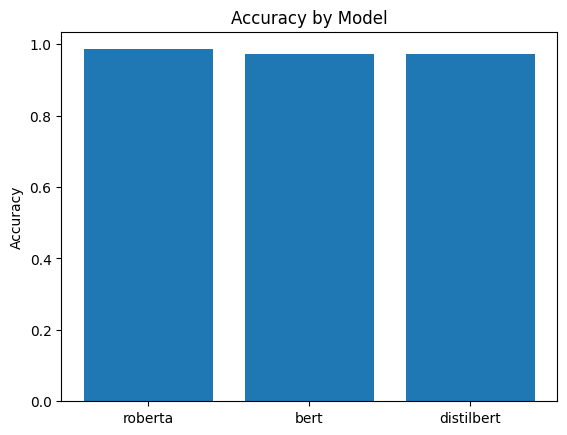

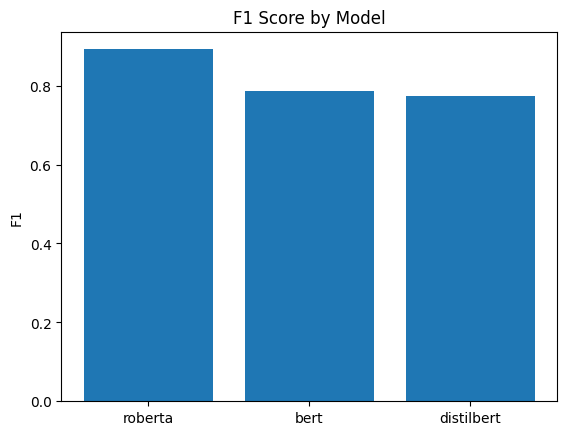

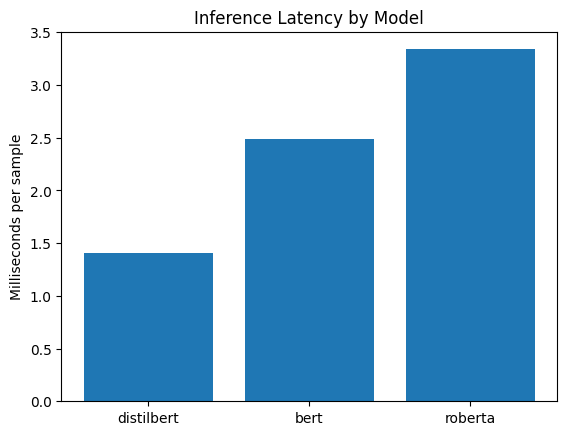

Saved figures in: /content/outputs


In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure()
plt.bar(results_df["model"], results_df["accuracy"])
plt.title("Accuracy by Model")
plt.ylabel("Accuracy")
plt.savefig(os.path.join(OUT_DIR, "fig_accuracy.png"), dpi=200)
plt.show()

# F1 plot
plt.figure()
plt.bar(results_df["model"], results_df["f1"])
plt.title("F1 Score by Model")
plt.ylabel("F1")
plt.savefig(os.path.join(OUT_DIR, "fig_f1.png"), dpi=200)
plt.show()

# Latency plot
plt.figure()
plt.bar(lat_df["model"], lat_df["ms_per_sample"])
plt.title("Inference Latency by Model")
plt.ylabel("Milliseconds per sample")
plt.savefig(os.path.join(OUT_DIR, "fig_latency.png"), dpi=200)
plt.show()

print("Saved figures in:", OUT_DIR)


In [ ]:
import zipfile, glob

zip_path = "/content/outputs.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for fp in glob.glob(f"{OUT_DIR}/**", recursive=True):
        if os.path.isfile(fp):
            z.write(fp, arcname=os.path.relpath(fp, OUT_DIR))

print("Created:", zip_path)


Created: /content/outputs.zip


In [ ]:
print(results_df)


        model  eval_loss  accuracy        f1  epoch
2     roberta   0.063155  0.986116  0.892388    2.0
1        bert   0.115885  0.973925  0.785515    2.0
0  distilbert   0.107708  0.972909  0.772727    2.0


In [ ]:
# Recreate /content/outputs and export ALL artifacts again (NO retraining)

import os
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from google.colab import files

OUT_DIR = "/content/outputs"
ZIP_PATH = "/content/outputs.zip"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) Rebuild results table (using your final reported metrics)
results_df = pd.DataFrame([
    {"model": "roberta",    "eval_loss": 0.063155, "accuracy": 0.986116, "f1": 0.892388, "epoch": 2.0},
    {"model": "bert",       "eval_loss": 0.115885, "accuracy": 0.973925, "f1": 0.785515, "epoch": 2.0},
    {"model": "distilbert", "eval_loss": 0.107708, "accuracy": 0.972909, "f1": 0.772727, "epoch": 2.0},
])

# Save CSV
results_csv = os.path.join(OUT_DIR, "results_metrics.csv")
results_df.to_csv(results_csv, index=False)

# 2) Rebuild figures (Accuracy, F1)
plt.figure()
plt.bar(results_df["model"], results_df["accuracy"])
plt.title("Accuracy by Model")
plt.ylabel("Accuracy")
plt.savefig(os.path.join(OUT_DIR, "fig_accuracy.png"), dpi=200)
plt.close()

plt.figure()
plt.bar(results_df["model"], results_df["f1"])
plt.title("F1 Score by Model")
plt.ylabel("F1")
plt.savefig(os.path.join(OUT_DIR, "fig_f1.png"), dpi=200)
plt.close()

# 3) Latency figure (only if latency_results.csv exists, otherwise skip gracefully)
latency_csv = os.path.join(OUT_DIR, "latency_results.csv")
# If you previously saved latency_results.csv elsewhere, put it into OUT_DIR first.
if os.path.exists("/content/latency_results.csv") and not os.path.exists(latency_csv):
    os.replace("/content/latency_results.csv", latency_csv)

if os.path.exists(latency_csv):
    lat_df = pd.read_csv(latency_csv)
    plt.figure()
    plt.bar(lat_df["model"], lat_df["ms_per_sample"])
    plt.title("Inference Latency by Model")
    plt.ylabel("Milliseconds per sample")
    plt.savefig(os.path.join(OUT_DIR, "fig_latency.png"), dpi=200)
    plt.close()
else:
    # Create a placeholder note (no fake numbers)
    with open(os.path.join(OUT_DIR, "LATENCY_NOTE.txt"), "w") as f:
        f.write("Latency file was not found in this runtime. "
                "Re-run the latency measurement cell to regenerate latency_results.csv and fig_latency.png.\n")

# 4) Zip outputs folder
with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as z:
    for root, dirs, fs in os.walk(OUT_DIR):
        for fn in fs:
            full_path = os.path.join(root, fn)
            arcname = os.path.relpath(full_path, OUT_DIR)
            z.write(full_path, arcname)

print("Recreated folder:", OUT_DIR)
print("Zipped to:", ZIP_PATH)
print("Files in outputs:", os.listdir(OUT_DIR))

# 5) Download ZIP
files.download(ZIP_PATH)



Recreated folder: /content/outputs
Zipped to: /content/outputs.zip
Files in outputs: ['ckpt_bert', 'predictions_roberta.csv', 'LATENCY_NOTE.txt', 'misclassified_roberta.csv', 'ckpt_roberta', 'predictions_bert.csv', 'train_split.csv', 'fig_accuracy.png', 'predictions_distilbert.csv', 'test_metrics_distilbert.json', 'fig_f1.png', 'results_metrics.csv', 'val_split.csv', 'fig_latency.png', 'test_metrics_roberta.json', 'test_metrics_bert.json', 'misclassified_bert.csv', 'latency_results.csv', 'test_split.csv', 'misclassified_distilbert.csv', 'ckpt_distilbert']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>